In [17]:
import numpy as np
import torch
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm

import pickle
import csv
import time
import sys

sys.path.append('src/')

# Own libraries
import utils
import trainer_WGAN as trainer
import model_WGAN
import WGAN
import models

torch.manual_seed(42)

In [15]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Encoding parameters
k = 4
n = 7
M = 16
TRAINING_SNR = 5
rate = k/n
noise_std = utils.EbNo_to_noise(TRAINING_SNR, rate)
save_every = 1000

#GAN parameters
g_input_size = 2*n      # Random noise dimension coming into generator, per output vector
g_hidden_size = 128 # Generator complexity
g_output_size = n     # Size of generated output vector

d_input_size = 2*n    # Minibatch size - cardinality of distributions
d_hidden_size = 128    # Discriminator complexity
d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification

batch_size = 5000
num_epochs = 20000

G = WGAN.Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)
D = WGAN.Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)
G = G.to(device)
D = D.to(device)

d_lr = 1e-4
g_lr = 1e-4

channel_awgn = model_WGAN.Channel_AWGN(noise_std)

In [3]:
G.load_state_dict(torch.load('state_dict_WGAN/G_AWGN-40.pt', map_location="cpu"))

<All keys matched successfully>

In [4]:
total_params_g = sum(p.numel() for p in G.parameters())
print('# of parameters (WGAN model Generator): ' + str(total_params_g))
total_params_d = sum(p.numel() for p in D.parameters())
print('# of parameters (WGAN model Critic): ' + str(total_params_d))

# of parameters (WGAN model Generator): 19335
# of parameters (WGAN model Critic): 18561


# Training WGAN


In [5]:
num_epochs = 20000
epochs = tqdm(range(num_epochs), ascii=True)
for epoch in epochs:
    kl, g_loss = WGAN.train_WGAN(G, D, batch_size, n, channel_awgn, d_lr, g_lr)
    if (epoch+1) % 50 == 0:
        epochs.set_description(f"Epoch {epoch+1}: KL Div {kl:.3e} G loss {-g_loss:.3e}")
    if (epoch+1) % save_every == 0:
        torch.save(G.state_dict(), f'state_dict_WGAN/G_AWGN-{(epoch+1)//save_every}.pt')
        torch.save(D.state_dict(), f'state_dict_WGAN/D_AWGN-{(epoch+1)//save_every}.pt')

    #    WGAN.plot_GAN(G, 10000,M, n, channel_awgn, epoch)

Epoch 20000: KL Div 1.738e-03 G loss 1.000e-02: 100%|#| 20000/20000 [07:21<00:00


In [6]:
num_epochs_prev = num_epochs
num_epochs = 10000
d_lr = 1e-5; g_lr = 1e-5
epochs = tqdm(range(num_epochs), ascii=True)
for epoch in epochs:
    kl, g_loss = WGAN.train_WGAN(G, D, batch_size, n, channel_awgn, d_lr, g_lr)
    if (epoch+1) % 50 == 0:
        epochs.set_description(f"Epoch {epoch+1}: KL Div {kl:.3e} G loss {-g_loss:.3e}")
    if (epoch+1) % save_every == 0:
        torch.save(G.state_dict(), f'state_dict_WGAN/G_AWGN-{(num_epochs_prev+epoch+1)//save_every}.pt')
        torch.save(D.state_dict(), f'state_dict_WGAN/D_AWGN-{(num_epochs_prev+epoch+1)//save_every}.pt')

    #    WGAN.plot_GAN(G, 10000,M, n, channel_awgn, epoch)

Epoch 10000: KL Div 1.906e-03 G loss 1.000e-02: 100%|#| 10000/10000 [04:19<00:00


Epoch 1:  


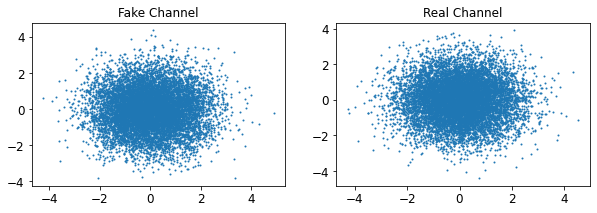

In [6]:
WGAN.plot_GAN(G, 10000, M, n, channel_awgn, 1)

In [7]:
## Measuring the sampling time

In [8]:
# Set the message samples to test out
num_samples = 2 ** 20 # per message
#m_sample = torch.eye(M)
#m = m_sample.repeat_interleave(num_samples, dim=0)
batch_size = 1024 

#encoder = models.Encoder_1h( M, n, n).to(device)
x = torch.ones(batch_size, n).to(device) 
t = time.time() # tic

#m_batched = torch.split(m, batch_size)
#for m_b in m_batched:
for i in range(num_samples // batch_size):
    #m_b = m_b.to(device)
    #x = encoder(m_b)
    x_seq = G(x)
    #samples_DDPM = x_seq[-1]
sampling_time_WGAN = time.time() - t # toc
print(sampling_time_WGAN)
np.save('results/t_WGAN_AWGN.npy', sampling_time_WGAN)

0.4778146743774414


# Training GAN Encoder

In [8]:
dataset = np.random.randint(0, M, size=10000000) # size = 10000000

In [16]:
encoder_GAN = models.Encoder_1h( M, n, n)
decoder_GAN = models.Decoder_1h( M, n)
channel = model_WGAN.Channel_GAN(encoder_GAN, decoder_GAN, G).to(device)
tconf = trainer.TrainerConfig(max_epochs=20, noise_std = noise_std, batch_size=1000, M=M, rate=rate) # epoch = 10, batch_size = 1000
weights = filter(lambda p: p.requires_grad, list(encoder_GAN.parameters())+list(decoder_GAN.parameters()))
t_gan = trainer.Trainer(channel, dataset, tconf, one_hot=True)
t_gan.train(weights=weights, GAN=True, global_epoch=0)

epoch 1: loss 4.51e-01 SER 1.49e-01: 100%|#| 10000/10000 [00:32<00:00, 309.42it/
epoch 2: loss 1.94e-01 SER 6.01e-02: 100%|#| 10000/10000 [00:47<00:00, 212.07it/
epoch 3: loss 1.71e-01 SER 5.35e-02: 100%|#| 10000/10000 [00:57<00:00, 172.87it/
epoch 4: loss 1.60e-01 SER 4.98e-02: 100%|#| 10000/10000 [00:56<00:00, 177.15it/
epoch 5: loss 1.53e-01 SER 4.78e-02: 100%|#| 10000/10000 [00:53<00:00, 187.09it/
epoch 6: loss 1.48e-01 SER 4.63e-02: 100%|#| 10000/10000 [00:53<00:00, 188.20it/
epoch 7: loss 1.44e-01 SER 4.51e-02: 100%|#| 10000/10000 [00:54<00:00, 184.06it/
epoch 8: loss 1.41e-01 SER 4.43e-02: 100%|#| 10000/10000 [00:58<00:00, 172.40it/
epoch 9: loss 1.39e-01 SER 4.36e-02: 100%|#| 10000/10000 [00:58<00:00, 172.09it/
epoch 10: loss 1.38e-01 SER 4.32e-02: 100%|#| 10000/10000 [00:58<00:00, 170.66it
epoch 11: loss 1.36e-01 SER 4.27e-02: 100%|#| 10000/10000 [00:59<00:00, 168.39it
epoch 12: loss 1.35e-01 SER 4.24e-02: 100%|#| 10000/10000 [00:59<00:00, 168.48it
epoch 13: loss 1.34e-01 SER 

In [10]:
torch.save(encoder_GAN.state_dict(), 'state_dict_WGAN/enc_GAN_AWGN.pt')
torch.save(decoder_GAN.state_dict(), 'state_dict_WGAN/dec_GAN_AWGN.pt')

# Training AE Encoder

In [18]:
encoder_AE = models.Encoder_1h(M, n, n)# models.Encoder_1h( M, n)
decoder_AE = models.Decoder_1h(M, n)
model_2 = model_WGAN.Channel_GAN(encoder_AE, decoder_AE, channel_awgn).to(device)
#model_2 = model_WGAN.Channel(encoder_AE, decoder_AE).to(device)

tconf = trainer.TrainerConfig(max_epochs=10, noise_std = noise_std, batch_size=1000, M=M, rate=rate)
weights = filter(lambda p: p.requires_grad, model_2.parameters())

t_ae = trainer.Trainer(model_2, dataset, tconf, one_hot=True)
t_ae.train(weights=weights, GAN=True)

epoch 1: loss 6.14e-02 SER 1.65e-02: 100%|#| 10000/10000 [00:30<00:00, 329.01it/
epoch 2: loss 1.36e-02 SER 4.57e-03: 100%|#| 10000/10000 [00:36<00:00, 272.82it/
epoch 3: loss 1.14e-02 SER 3.83e-03: 100%|#| 10000/10000 [00:36<00:00, 271.41it/
epoch 4: loss 1.10e-02 SER 3.71e-03: 100%|#| 10000/10000 [00:37<00:00, 269.70it/
epoch 5: loss 1.07e-02 SER 3.57e-03: 100%|#| 10000/10000 [00:38<00:00, 260.27it/
epoch 6: loss 1.06e-02 SER 3.55e-03: 100%|#| 10000/10000 [00:40<00:00, 248.66it/
epoch 7: loss 1.06e-02 SER 3.54e-03: 100%|#| 10000/10000 [00:36<00:00, 277.32it/
epoch 8: loss 1.05e-02 SER 3.53e-03: 100%|#| 10000/10000 [00:38<00:00, 258.88it/
epoch 9: loss 1.05e-02 SER 3.51e-03: 100%|#| 10000/10000 [00:40<00:00, 247.93it/
epoch 10: loss 1.05e-02 SER 3.52e-03: 100%|#| 10000/10000 [00:40<00:00, 248.69it


# Testing AE & GAN Encoder under real channel

In [19]:
dataset = np.random.randint(0,M, size=10000000)

In [ ]:
bler_testGAN =[]
ebno_range = [2, 3, 4, 5, 6, 7, 8]

model_testGAN = model_WGAN.Channel(encoder_GAN, decoder_GAN).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testGAN = trainer.Trainer(model_testAE, dataset, tconf, one_hot=True)


bler_testGAN = t_testAE.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

In [21]:
bler_testAE =[]
ebno_range = [2, 3, 4, 5, 6, 7, 8]

model_testAE = model_WGAN.Channel(encoder_AE, decoder_AE).to(device)
tconf = trainer.TrainerConfig(max_epochs=5, noise_std = noise_std, batch_size=1000, M=M, rate=rate)

t_testAE = trainer.Trainer(model_testAE, dataset, tconf, one_hot=True)


bler_testAE = t_testAE.test(snr_range=ebno_range, one_hot=True, erasure_bound=0.7)

SNR 7  iter 9900: SER 1.055e-04: 100%|###| 10000/10000 [00:19<00:00, 512.60it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 7  iter 9900: SER 1.085e-04: 100%|###| 10000/10000 [00:18<00:00, 531.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 7  iter 9900: SER 1.124e-04: 100%|###| 10000/10000 [00:20<00:00, 488.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 8  iter 9900: SER 9.595e-06: 100%|###| 10000/10000 [00:18<00:00, 533.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  20000000


SNR 8  iter 9900: SER 1.121e-05: 100%|###| 10000/10000 [00:18<00:00, 542.52it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  30000000


SNR 8  iter 9900: SER 1.050e-05: 100%|###| 10000/10000 [00:16<00:00, 593.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  40000000


SNR 8  iter 9900: SER 1.141e-05: 100%|###| 10000/10000 [00:17<00:00, 581.04it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  50000000


SNR 8  iter 9900: SER 9.999e-06: 100%|###| 10000/10000 [00:18<00:00, 546.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  60000000


SNR 8  iter 9900: SER 1.101e-05: 100%|###| 10000/10000 [00:18<00:00, 536.56it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  70000000


SNR 8  iter 9900: SER 1.101e-05: 100%|###| 10000/10000 [00:18<00:00, 538.30it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  80000000


SNR 8  iter 9900: SER 1.192e-05: 100%|###| 10000/10000 [00:16<00:00, 594.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  90000000


SNR 8  iter 9900: SER 1.081e-05: 100%|###| 10000/10000 [00:16<00:00, 601.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  100000000


SNR 8  iter 9900: SER 7.979e-06: 100%|###| 10000/10000 [00:17<00:00, 578.70it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  110000000


SNR 8  iter 9900: SER 1.161e-05: 100%|###| 10000/10000 [00:20<00:00, 491.23it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  120000000


SNR 8  iter 9900: SER 9.999e-06: 100%|###| 10000/10000 [00:21<00:00, 474.71it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  130000000


SNR 8  iter 9900: SER 1.060e-05: 100%|###| 10000/10000 [00:20<00:00, 493.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  140000000


SNR 8  iter 9900: SER 1.060e-05: 100%|###| 10000/10000 [00:20<00:00, 492.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  150000000


SNR 8  iter 9900: SER 9.595e-06: 100%|###| 10000/10000 [00:20<00:00, 490.58it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  160000000


SNR 8  iter 9900: SER 8.080e-06: 100%|###| 10000/10000 [00:20<00:00, 489.29it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  170000000


SNR 8  iter 9900: SER 1.202e-05: 100%|###| 10000/10000 [00:22<00:00, 443.19it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  180000000


SNR 8  iter 9900: SER 1.091e-05: 100%|###| 10000/10000 [00:23<00:00, 425.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  190000000


SNR 8  iter 9900: SER 9.191e-06: 100%|###| 10000/10000 [00:22<00:00, 436.44it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  200000000


SNR 8  iter 9900: SER 9.393e-06: 100%|###| 10000/10000 [00:23<00:00, 430.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  210000000


SNR 8  iter 9900: SER 1.060e-05: 100%|###| 10000/10000 [00:23<00:00, 434.05it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  220000000


SNR 8  iter 9900: SER 1.030e-05: 100%|###| 10000/10000 [00:22<00:00, 436.90it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  230000000


SNR 8  iter 9900: SER 1.040e-05: 100%|###| 10000/10000 [00:22<00:00, 441.24it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  240000000


SNR 8  iter 9900: SER 1.141e-05: 100%|###| 10000/10000 [00:26<00:00, 382.73it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  250000000


SNR 8  iter 9900: SER 9.292e-06: 100%|###| 10000/10000 [00:25<00:00, 388.21it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  260000000


SNR 8  iter 9900: SER 9.494e-06: 100%|###| 10000/10000 [00:24<00:00, 408.12it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  270000000


SNR 8  iter 9900: SER 8.282e-06: 100%|###| 10000/10000 [00:22<00:00, 443.25it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  280000000


SNR 8  iter 9900: SER 1.081e-05: 100%|###| 10000/10000 [00:23<00:00, 432.69it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  290000000


SNR 8  iter 9900: SER 1.020e-05: 100%|###| 10000/10000 [00:25<00:00, 387.27it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  300000000


SNR 8  iter 9900: SER 9.696e-06: 100%|###| 10000/10000 [00:25<00:00, 398.79it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  310000000


SNR 8  iter 9900: SER 9.393e-06: 100%|###| 10000/10000 [00:24<00:00, 402.93it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  320000000


SNR 8  iter 9900: SER 1.111e-05: 100%|###| 10000/10000 [00:24<00:00, 401.16it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  330000000


SNR 8  iter 9900: SER 9.494e-06: 100%|###| 10000/10000 [00:24<00:00, 400.13it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  340000000


SNR 8  iter 9900: SER 1.020e-05: 100%|###| 10000/10000 [00:24<00:00, 400.66it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  350000000


SNR 8  iter 9900: SER 9.696e-06: 100%|###| 10000/10000 [00:25<00:00, 394.97it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  360000000


SNR 8  iter 9900: SER 1.091e-05: 100%|###| 10000/10000 [00:24<00:00, 401.18it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  370000000


SNR 8  iter 9900: SER 1.030e-05: 100%|###| 10000/10000 [00:25<00:00, 397.63it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  380000000


SNR 8  iter 9900: SER 9.292e-06: 100%|###| 10000/10000 [00:24<00:00, 401.65it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  390000000


SNR 8  iter 9900: SER 1.071e-05: 100%|###| 10000/10000 [00:25<00:00, 398.98it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  400000000


SNR 8  iter 9900: SER 8.282e-06: 100%|###| 10000/10000 [00:24<00:00, 405.01it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  410000000


SNR 8  iter 9900: SER 1.121e-05: 100%|###| 10000/10000 [00:25<00:00, 396.43it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  420000000


SNR 8  iter 9900: SER 1.202e-05: 100%|###| 10000/10000 [00:25<00:00, 399.62it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  430000000


SNR 8  iter 9900: SER 1.030e-05: 100%|###| 10000/10000 [00:25<00:00, 399.82it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  440000000


SNR 8  iter 9900: SER 1.182e-05: 100%|###| 10000/10000 [00:24<00:00, 404.74it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  450000000


SNR 8  iter 9900: SER 9.393e-06: 100%|###| 10000/10000 [00:25<00:00, 399.75it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  460000000


SNR 8  iter 9900: SER 8.787e-06: 100%|###| 10000/10000 [00:24<00:00, 404.38it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  470000000


SNR 8  iter 9900: SER 1.182e-05: 100%|###| 10000/10000 [00:25<00:00, 399.88it/s]


The number of samples is not enough. One more epoch is running. Total # of samples used:  480000000


SNR 8  iter 9900: SER 1.010e-05: 100%|###| 10000/10000 [00:24<00:00, 403.99it/s]


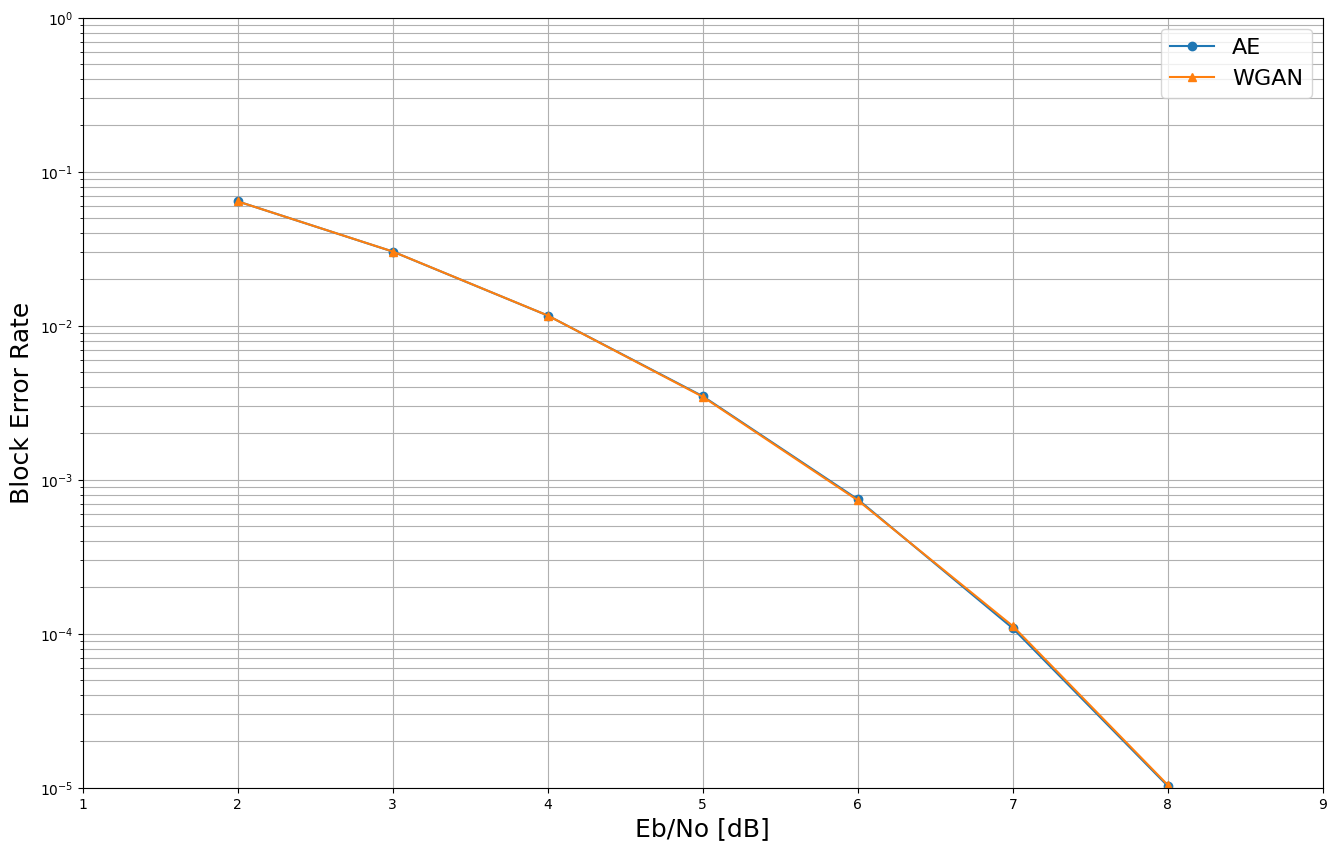

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16, 10))
# Plot Autoencoder
plt.semilogy(ebno_range, bler_testAE, 'o-')
#plt.semilogy(bber_data[0], bber_data[2], 'o-')
#plt.semilogy(bber_data[0], vec, 'o-')

plt.semilogy(ebno_range, bler_testGAN, '^-')

# Plot approx 16 QAM
#ebnodbs = np.linspace(5,14,10)
#a, _ = utils.MQAM_rayleigh_approx(16,ebnodbs)
#plt.plot(ebnodbs, a, '^-');

#b = [utils.rayleigh_error(t) for t in ebnodbs]
#plt.plot(ebnodbs, b, '^-');

#ebnodbs = np.linspace(0,11,22)
#uncoded_16QAM_Rayleigh_SER = [0.5501, 0.5040, 0.4564, 0.4082, 0.3606, 0.3147, 0.2713, 0.2313, 0.1951, 0.1631, 0.1352, 0.1112, 0.091, 0.07396, 0.05989, 0.04832, 0.03886, 0.03119, 0.02497, 0.01996, 0.01594, 0.01271]
#c = [(1-(1-t)**4) for t in uncoded_16QAM_Rayleigh_SER]
#plt.plot(ebnodbs, c, '^-');

plt.gca().set_ylim(1e-5, 1)
plt.gca().set_xlim(1, 9)
plt.ylabel("Block Error Rate", fontsize=18, rotation=90)
plt.xlabel("Eb/No [dB]", fontsize=18)
plt.legend(['AE', 'WGAN'], prop={'size': 16}, loc='upper right');
plt.grid(True, which="both")
#plt.savefig('ae-ray-testing.pdf')